# One-Zone Model Degeneracies

Looking for degeneracies between Ia DTD and other parameters in the one-zone model outputs.

In [49]:
from pathlib import Path
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, ScalarFormatter
import vice

# VICE yields
from vice.yields.presets import JW20
vice.yields.ccsne.settings['fe'] += 0.07

# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
    'font.family': 'STIXgeneral',
    'mathtext.fontset': 'cm',
})

# Simulation time
TMAX = 13.2 # Gyr
DT = 0.01 # Gyr
simtime = np.arange(0, TMAX+DT, DT) # Gyr

# Stellar mass of Milky Way (Licquia & Newman 2015, ApJ, 806, 96)
M_STAR_MW = 5.17e10

# Default parameters
params = dict(
    elements=('fe', 'o'),
    delay=0.04,
    mode='sfr',
    dt=DT,
    eta=2.15,
)

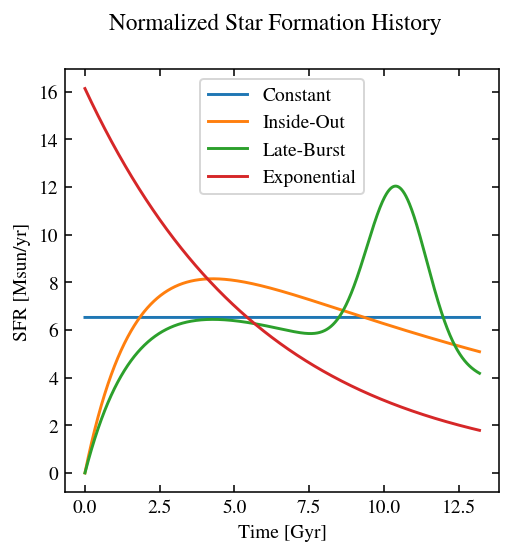

In [26]:
# Star formation history functions
def f_c(t):
    """
    Constant star formation history as a function of time.
    """
    return 1

def f_io(t, tau_rise=2, tau_sfh=15):
    """
    Inside-out star formation history as a function of time.
    t : time in Gyr
    tau_rise : rise timescale in Gyr
    tau_sfh : star formation history timescale in Gyr
    """
    return (1 - m.exp(-t/tau_rise)) * m.exp(-t/tau_sfh)

def f_lb(t, Ab=1.5, tb=10.5, sigma_b=1, **kwargs):
    """
    Inside-out star formation history modified to include a late burst.
    t : time in Gyr
    Ab : dimensionless strength of starburst
    tb : time of local maximum in SFH during burst in Gyr
    sigma_b : width of Gaussian describing burst in Gyr
    """
    burst = Ab * m.exp(-(t-tb)**2/(2*sigma_b**2))
    return f_io(t, **kwargs) * (1 + burst)

def f_exp(t, tau_sfh=6):
    """
    Exponentially declining star formation rate.
    t : time in Gyr
    tau_sfh : exponential timescale in Gyr
    """
    sfr = 1/tau_sfh * m.exp(-t/tau_sfh)
    return sfr

def normalize(func, dt=DT, recycling=0.4, tmax=TMAX, Mstar=M_STAR_MW):
    """
    Compute normalization pre-factor for star formation function.
    """
    time_integral = sum([func(i * dt) * dt * 1e9 for i in range(int(tmax / dt))])

    return Mstar / ((1 - recycling) * time_integral)

A_c = normalize(f_c)
A_io = normalize(f_io)
A_lb = normalize(f_lb)
A_exp = normalize(f_exp)

def const_sfh(t):
    return A_c * f_c(t)

def insideout(t):
    return A_io * f_io(t)

def lateburst(t):
    return A_lb * f_lb(t)

def exp_sfh(t):
    return A_exp * f_exp(t)

fig, ax = plt.subplots()
ax.plot(simtime, [const_sfh(t) for t in simtime], label='Constant')
ax.plot(simtime, [insideout(t) for t in simtime], label='Inside-Out')
ax.plot(simtime, [lateburst(t) for t in simtime], label='Late-Burst')
ax.plot(simtime, [exp_sfh(t) for t in simtime], label='Exponential')
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel('SFR [Msun/yr]')
ax.legend()
fig.suptitle('Normalized Star Formation History')
plt.show()

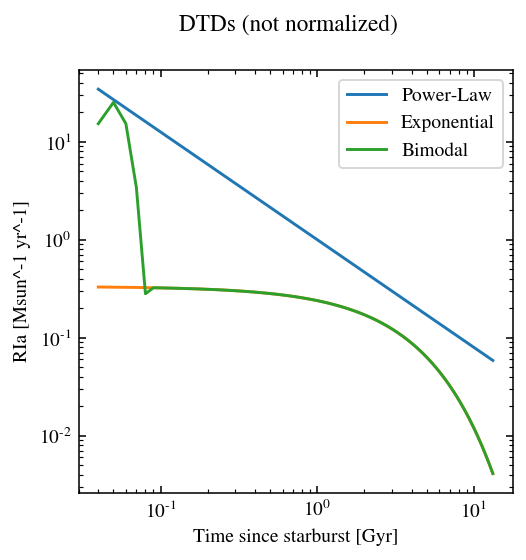

In [27]:
# Delay time distributions
class Exponential:
    """
    The exponential delay-time distribution of SNe Ia.

    Parameters
    ----------
    timescale : float [default: 3]
        The e-folding timescale in Gyr of the exponential.
    norm : float [default: 1]
        The normalization of the exponential, i.e., the value at t=0.
    
    """
    def __init__(self, timescale=3, norm=1):
        self.timescale = timescale
        self.norm = norm

    def __call__(self, time):
        return self.norm * 1/self.timescale * m.exp(-time/self.timescale)


class Powerlaw:
    """
    The power-law delay-time distribution of SNe Ia.

    Parameters
    ----------
    slope : float [default: -1.1]
        The slope of the power law.
    norm : float [default: 1]
        The normalization of the power law, i.e., the value at t=1.
        
    """
    def __init__(self, slope=-1.1, norm=1):
        self.slope = slope
        self.norm = norm

    def __call__(self, time):
        return self.norm * time ** self.slope


class Gaussian:
    """
    A Gaussian distribution in time.

    Parameters
    ----------
    center : float [default: 1]
        The location of the peak of the Gaussian function.
    stdev : float [default: 1]
        The standard deviation of the Gaussian function.
    norm : float [default: 1]
        The normalization of the Gaussian function, i.e., the value of the peak.
        
    """
    def __init__(self, center=1, stdev=1, norm=1):
        self.center = center
        self.stdev = stdev
        self.norm = norm

    def __call__(self, time):
        return self.norm * m.exp(-(time-self.center)**2 / (2*self.stdev**2))


class Bimodal(Gaussian, Exponential):
    """
    The bimodal delay-time distribution of SNe Ia. This assumes 50% of SNe Ia
    belong to a prompt component with the form of a narrow Gaussian, and the
    remaining 50% form an exponential DTD.

    Parameters
    ----------
    tsplit : float [default: 0.09]
        Time in Gyr separating the prompt component of SNe Ia from the tardy component.
    prompt : float [default: 0.5]
        Fraction of SNe Ia in the prompt component.
    center : float [default: 0.05]
        Center of the prompt Gaussian component in Gyr.
    stdev : float [default: 0.01]
        Spread of the prompt Gaussian component in Gyr.
    timescale : float [default: 3]
        Timescale of the tardy exponential in Gyr.
    delay : float [default: 0.04]
        Minimum delay time in Gyr.
    tmax : float [default: 13.2]
        Maximum simulation time in Gyr.
        
    """
    def __init__(self, tsplit=0.09, prompt=0.5, center=0.05, stdev=0.01, timescale=3, delay=0.04, tmax=TMAX):
        self.tsplit = tsplit
        Gaussian.__init__(self, center=center, stdev=stdev)
        Exponential.__init__(self, timescale=timescale)
        # Set relative scale of components
        niter = 1000
        gauss_sum = sum([Gaussian.__call__(self, (tsplit-delay)/niter * t + delay) \
                 * tsplit/niter for t in range(niter)])
        exp_sum = sum([Exponential.__call__(self, (tmax-tsplit)/niter * t + tsplit) \
                 * (tmax-tsplit)/niter for t in range(niter)])
        self.scale_gaussian = (exp_sum * prompt) / (gauss_sum * (1 - prompt))

    def __call__(self, time):
        if time < self.tsplit:
            return self.scale_gaussian * Gaussian.__call__(self, time)
        else:
            return Exponential.__call__(self, time)


plaw_dtd = Powerlaw()
exp_dtd = Exponential()
bi_dtd = Bimodal()

fig, ax = plt.subplots()
tarr = np.arange(0.04, TMAX+DT, DT) # Gyr
ax.plot(tarr, [plaw_dtd(t) for t in tarr], label='Power-Law')
ax.plot(tarr, [exp_dtd(t) for t in tarr], label='Exponential')
ax.plot(tarr, [bi_dtd(t) for t in tarr], label='Bimodal')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time since starburst [Gyr]')
ax.set_ylabel('RIa [Msun^-1 yr^-1]')
ax.legend()
fig.suptitle('DTDs (not normalized)')
plt.show()

In [28]:
sz = vice.singlezone(name='singlezone/constant/powerlaw', func=const_sfh, RIa=plaw_dtd, **params)
print(sz)

vice.singlezone{
    name -----------> singlezone/constant/powerlaw
    func -----------> <function const_sfh at 0x7f0dc5c071f0>
    mode -----------> sfr
    verbose --------> False
    elements -------> ('fe', 'o')
    IMF ------------> kroupa
    eta ------------> 2.15
    enhancement ----> 1.0
    entrainment ----> <entrainment settings>
    Zin ------------> 0.0
    recycling ------> continuous
    delay ----------> 0.04
    RIa ------------> <__main__.Powerlaw object at 0x7f0dc58a6a90>
    Mg0 ------------> 6000000000.0
    smoothing ------> 0.0
    tau_ia ---------> 1.5
    tau_star -------> 2.0
    schmidt --------> False
    schmidt_index --> 0.5
    MgSchmidt ------> 6000000000.0
    dt -------------> 0.01
    m_upper --------> 100.0
    m_lower --------> 0.08
    postMS ---------> 0.1
    Z_solar --------> 0.014
    bins -----------> [-3, -2.95, -2.9, ... , 0.9, 0.95, 1]
}


In [24]:
sz.run(simtime)

In [29]:
sz = vice.singlezone(name='singlezone/constant/exponential', func=const_sfh, RIa=exp_dtd, **params)
sz.run(simtime)
sz = vice.singlezone(name='singlezone/constant/bimodal', func=const_sfh, RIa=bi_dtd, **params)
sz.run(simtime)

sz = vice.singlezone(name='singlezone/insideout/powerlaw', func=insideout, RIa=plaw_dtd, **params)
sz.run(simtime)
sz = vice.singlezone(name='singlezone/insideout/exponential', func=insideout, RIa=exp_dtd, **params)
sz.run(simtime)
sz = vice.singlezone(name='singlezone/insideout/bimodal', func=insideout, RIa=bi_dtd, **params)
sz.run(simtime)

sz = vice.singlezone(name='singlezone/lateburst/powerlaw', func=lateburst, RIa=plaw_dtd, **params)
sz.run(simtime)
sz = vice.singlezone(name='singlezone/lateburst/exponential', func=lateburst, RIa=exp_dtd, **params)
sz.run(simtime)
sz = vice.singlezone(name='singlezone/lateburst/bimodal', func=lateburst, RIa=bi_dtd, **params)
sz.run(simtime)

sz = vice.singlezone(name='singlezone/exponential/powerlaw', func=exp_sfh, RIa=plaw_dtd, **params)
sz.run(simtime)
sz = vice.singlezone(name='singlezone/exponential/exponential', func=exp_sfh, RIa=exp_dtd, **params)
sz.run(simtime)
sz = vice.singlezone(name='singlezone/exponential/bimodal', func=exp_sfh, RIa=bi_dtd, **params)
sz.run(simtime)

In [43]:
def tri_plot(tlim=(-1, 14), felim=(-2, 1), olim=(-0.3, 0.5)):
    """Format triple-panel plot of metallicity and alpha abundance."""
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # First panel: metallicity vs time
    ax = axs[0]
    ax.set_xlim(tlim)
    ax.set_ylim(felim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[Fe/H]')

    # Second panel: alpha vs time
    ax = axs[1]
    ax.set_xlim(tlim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('Time [Gyr]')
    ax.set_ylabel('[O/Fe]')

    # Third panel: alpha vs fe
    ax = axs[2]
    ax.set_xlim(felim)
    ax.set_ylim(olim)
    ax.xaxis.set_minor_locator(MultipleLocator(0.1))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.05))
    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.set_xlabel('[Fe/H]')
    ax.set_ylabel('[O/Fe]')
    
    return fig, axs

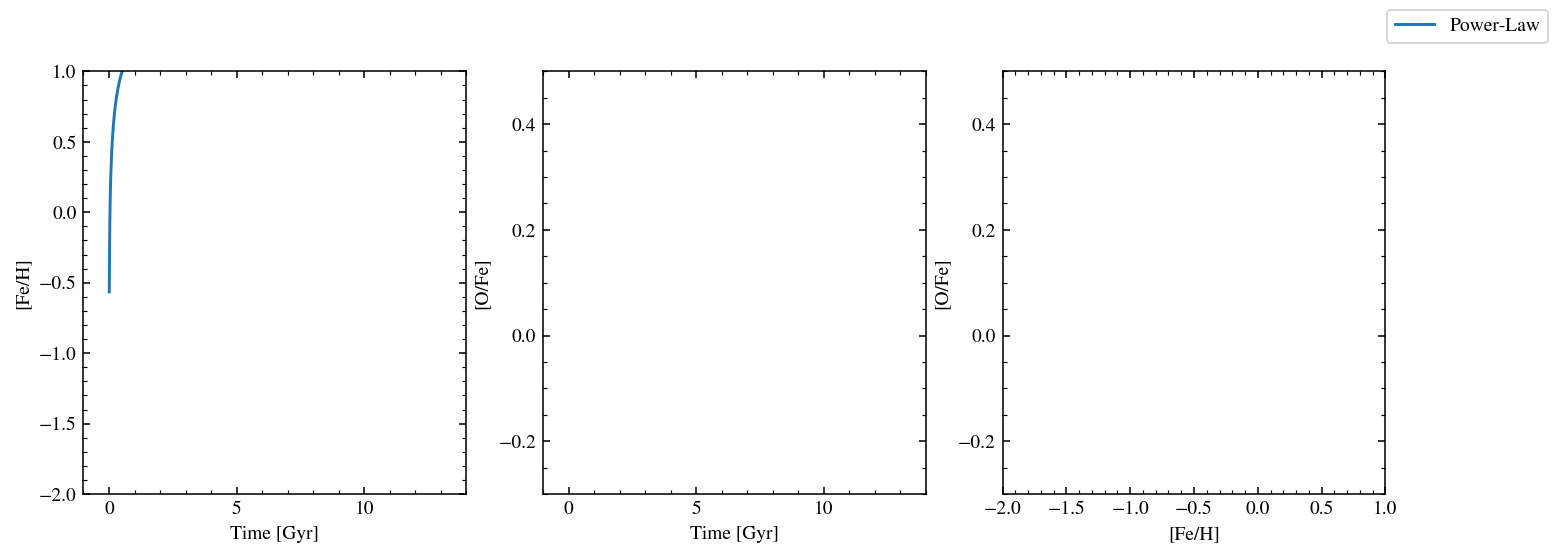

In [50]:
fig, axs = tri_plot()
history = vice.history('singlezone/constant/powerlaw')
axs[0].plot(history['time'], history['[fe/h]'], label='Power-Law')
axs[1].plot(history['time'], history['[o/fe]'])
axs[2].plot(history['[fe/h]'], history['[o/fe]'])
fig.legend()
plt.show()

## Old stuff

In [49]:
# Power-law DTD with shorter 40 Myr delay time
sz = vice.singlezone(name='sz_short', elements=('o', 'fe'), RIa='plaw', delay=0.04)
sz.run(simtime)

In [73]:
# Exponential DTDs
# Medium timescale
sz = vice.singlezone(name='sz_exp', elements=('o', 'fe'), RIa='exp', tau_ia=1.5)
sz.run(simtime)
# Short timescale
sz = vice.singlezone(name='sz_sexp', elements=('o', 'fe'), RIa='exp', tau_ia=0.5)
sz.run(simtime)
# Long timescale
sz = vice.singlezone(name='sz_lexp', elements=('o', 'fe'), RIa='exp', tau_ia=5.5)
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_exp.vice
Overwite? (y | n)  y


In [8]:
# Wide gaussian DTD
def gauss(t, sigma=1, center=1):
    return np.exp(-(t-center)**2/(2*sigma**2))

sz = vice.singlezone(name='sz_wgauss', elements=('o', 'fe'), RIa=lambda t: gauss(t, sigma=2, center=3))
sz.run(simtime)

/home/lodubay/anaconda3/lib/python3.9/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: RIa
  warnings.warn("""\


In [38]:
# Narrow gaussian DTD
sz = vice.singlezone(name='sz_ngauss', elements=('o', 'fe'), RIa=lambda t: gauss(t, sigma=0.2, center=1))
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_ngauss.vice
Overwite? (y | n)  y


In [42]:
# Bimodal DTD
def bimodal(t, tau_ia=0.09):
    if t < tau_ia:
        return 10**(1.4 - 50*(np.log10(t*1e9) - 7.7)**2)
    else:
        return 10**(-0.8 - 0.9*(np.log10(t*1e9) - 8.7)**2)
    
sz = vice.singlezone(name='sz_bi', elements=('o', 'fe'), RIa=bimodal, delay=0.04)
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_bi.vice
Overwite? (y | n)  y


In [36]:
# Uniform DTD
def uniform(t, tmin=0, tmax=1):
    if t >= tmin and t < tmax:
        return 1
    else:
        return 0

sz = vice.singlezone(name='sz_uni', elements=('o', 'fe'), RIa=uniform)
sz.run(simtime)

Plot Fe vs time, alpha vs time, and alpha vs Fe.

In [70]:
sz = vice.singlezone(name='sz_long_sfe', elements=('o', 'fe'), tau_star=5)
sz.run(simtime)

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: sz_long_sfe.vice
Overwite? (y | n)  y


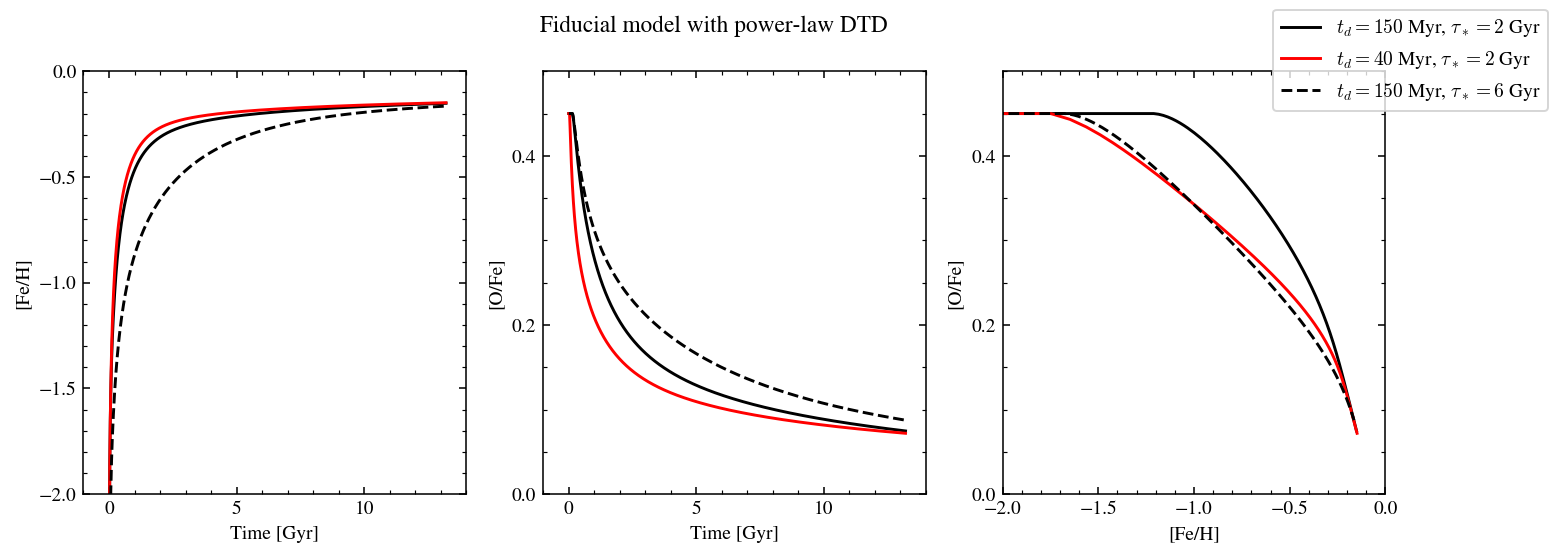

In [93]:
# Altering minimum delay time vs star formation efficiency timescale
fig, axs = tri_plot(felim=(-2, 0), olim=(0, 0.5))
                                         
# 150 Myr delay
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.15, tau_star=2)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=150$ Myr, $\tau_*=2$ Gyr'
style = 'k'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# 40 Myr delay
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.04, tau_star=2)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=40$ Myr, $\tau_*=2$ Gyr'
style = 'r'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# 150 Myr delay with 5 Gyr SFE timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='plaw', delay=0.15, tau_star=6)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$t_d=150$ Myr, $\tau_*=6$ Gyr'
style = 'k--'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

fig.suptitle('Fiducial model with power-law DTD')
fig.legend()
plt.show()

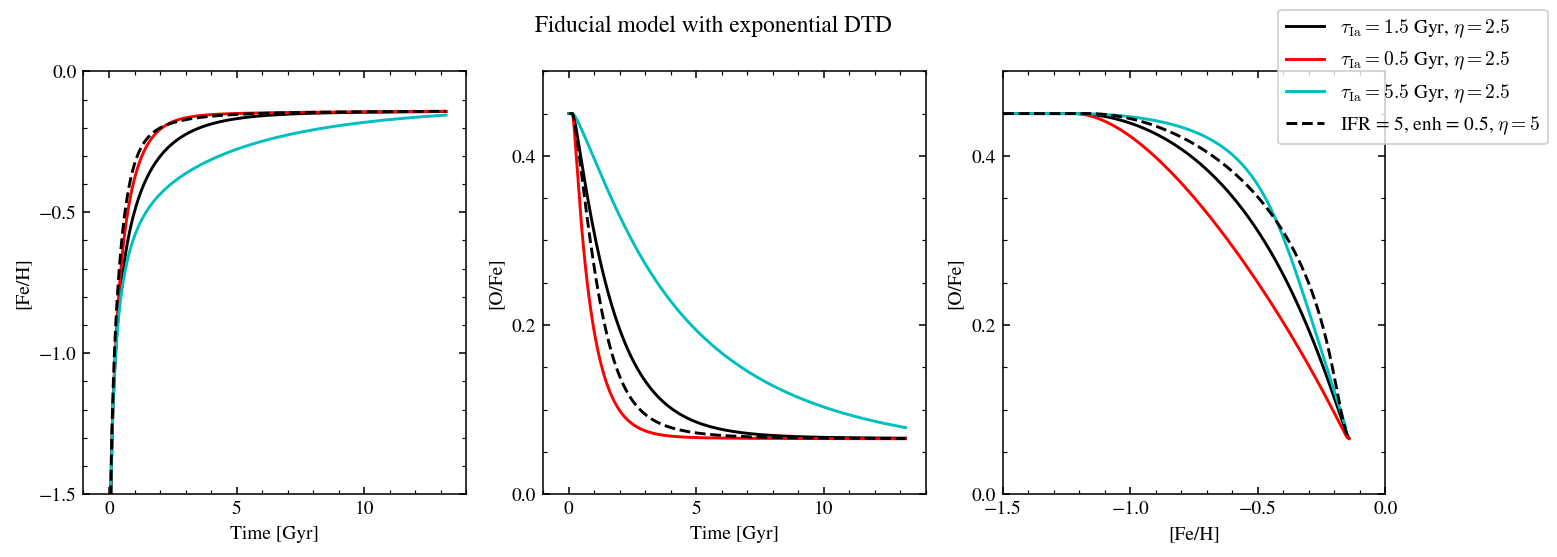

In [146]:
# Altering exponential Ia timescale vs star formation efficiency timescale
fig, axs = tri_plot(felim=(-1.5, 0), olim=(0, 0.5))
                                         
# Fiducial Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=1.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=1.5$ Gyr, $\eta=2.5$'
style = 'k'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Shorter Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=0.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=0.5$ Gyr, $\eta=2.5$'
style = 'r'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Longer Ia timescale
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=5.5, eta=2.5, enhancement=1)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = r'$\tau_{\rm{Ia}}=5.5$ Gyr, $\eta=2.5$'
style = 'c'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

# Other parameter changes
# need to set Mg0
sz = vice.singlezone(name='sz', elements=('o', 'fe'), RIa='exp', tau_ia=1.5, mode='ifr', func=lambda t: 5, enhancement=0.5, eta=5)
sz.run(simtime, overwrite=True)
history = vice.history('sz')
label = 'IFR = 5, enh = 0.5, $\eta=5$'
style = 'k--'
axs[0].plot(history['time'][1:], history['[fe/h]'][1:], style, label=label)
axs[1].plot(history['time'][1:], history['[o/fe]'][1:], style)
axs[2].plot(history['[fe/h]'][1:], history['[o/fe]'][1:], style)

fig.suptitle('Fiducial model with exponential DTD')
fig.legend()
plt.show()